# Amazon Dataset Cleaning

In [1]:
# imports
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

## Import SQL Data Using Sqlalchemy

In [2]:
# Database credentials
username = 'postgres'
password = 'hellosql'
host = 'localhost'
port = '5433'
database = 'da_project_streaming'

# Connection String
connection_string = f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}'

# Engine
engine = create_engine(connection_string)

In [3]:
# select all from amazon database
query = "SELECT * FROM amazon_prime_titles"
df_amazon = pd.DataFrame(engine.connect().execute(text(query)))

In [4]:
df_amazon.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,None,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,None,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,None,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,None,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


## Check for Duplicates/ NULL Values

In [5]:
df_amazon.duplicated().sum() # No duplicated values

0

In [6]:
df_amazon.isna().sum()

show_id            0
type               0
title              0
director        2082
cast            1233
country         8996
date_added      9513
release_year       0
rating           337
duration           0
listed_in          0
description        0
dtype: int64

In [7]:
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type          9668 non-null   object
 2   title         9668 non-null   object
 3   director      7586 non-null   object
 4   cast          8435 non-null   object
 5   country       672 non-null    object
 6   date_added    155 non-null    object
 7   release_year  9668 non-null   int64 
 8   rating        9331 non-null   object
 9   duration      9668 non-null   object
 10  listed_in     9668 non-null   object
 11  description   9668 non-null   object
dtypes: int64(1), object(11)
memory usage: 906.5+ KB


# Clean Data

In [8]:
# drop some null values
df_amazon.dropna(subset='rating', inplace=True)
df_amazon.drop('date_added', axis=1, inplace=True) # date_added mostly null so drop
# fill unknown director and cast with empty str
df_amazon['director'] = df_amazon['director'].fillna('unknown')
df_amazon['cast'] = df_amazon['cast'].fillna('unknown')
df_amazon['country'] = df_amazon['country'].fillna('unknown')
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9331 entries, 1 to 9667
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9331 non-null   object
 1   type          9331 non-null   object
 2   title         9331 non-null   object
 3   director      9331 non-null   object
 4   cast          9331 non-null   object
 5   country       9331 non-null   object
 6   release_year  9331 non-null   int64 
 7   rating        9331 non-null   object
 8   duration      9331 non-null   object
 9   listed_in     9331 non-null   object
 10  description   9331 non-null   object
dtypes: int64(1), object(10)
memory usage: 874.8+ KB


In [9]:
df_amazon['rating'].unique()

array(['13+', 'ALL', '18+', 'R', 'TV-Y', 'TV-Y7', 'NR', '16+', 'TV-PG',
       '7+', 'TV-14', 'TV-NR', 'TV-G', 'PG-13', 'TV-MA', 'G', 'PG',
       'NC-17', 'UNRATED', '16', 'AGES_16_', 'AGES_18_', 'ALL_AGES',
       'NOT_RATE'], dtype=object)

In [10]:
# Fix rating for shows so there are not multiple that mean the same thing
def fix_ratings(string):
    if string == 'ALL_AGES' or string == 'ALL':
        return 'G'
    elif string == 'NOT_RATE':
        return 'NR'
    elif string == 'UNRATED':
        return 'UR'
    elif string == '16' or string == 'AGES_16_':
        return '16+'
    elif string == 'AGES_18_':
        return '18+'
    else:
        return string

In [11]:
# apply function to normalize ratings
df_amazon['rating'] = df_amazon['rating'].apply(fix_ratings)
df_amazon['rating'].unique()

array(['13+', 'G', '18+', 'R', 'TV-Y', 'TV-Y7', 'NR', '16+', 'TV-PG',
       '7+', 'TV-14', 'TV-NR', 'TV-G', 'PG-13', 'TV-MA', 'PG', 'NC-17',
       'UR'], dtype=object)

In [12]:
df_amazon.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [13]:
def new_duration(string):
    return int(string.split()[0])

In [14]:
df_amazon['duration'] = df_amazon['duration'].apply(new_duration)
df_amazon['duration'].head()

1     110
15      1
17     87
18      1
19      1
Name: duration, dtype: int64

In [15]:
df_shows = df_amazon[df_amazon['type'] == 'TV Show']
df_shows.head()

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
15,s87,TV Show,Wipeout Canada,unknown,"Ennis Esmer, Jonathan Torrens, Jessica Phillips",unknown,2011,G,1,"Comedy, Documentary, Unscripted",Daring Canadian contestants are in pursuit of ...
18,s18,TV Show,Zoo Babies,unknown,Narrator - Gillian Barlett,unknown,2008,G,1,"Kids, Special Interest",A heart warming and inspiring series that welc...
19,s19,TV Show,Zoë Coombs Marr: Bossy Bottom,unknown,Zoë Coombs Marr,unknown,2020,18+,1,"Comedy, Talk Show and Variety",Zoë Coombs Marr has been on hiatus. Sort of. F...
21,s21,TV Show,Zoboomafoo,unknown,unknown,unknown,2001,TV-Y,1,Kids,Chris and Martin Kratt bring their enthusiasm ...
22,s22,TV Show,Zo Zo Zombie: Mini-Series,unknown,"Alex Cazares, Ben Diskin, Cristina Vee, Erika ...",unknown,2020,TV-Y7,1,"Action, Anime, Comedy","Zo Zo Zombie is our undead hero who, with his ..."


In [16]:
df_movies = df_amazon[df_amazon['type'] == 'Movie']
df_movies.head()

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,2018,13+,110,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
17,s17,Movie,Zoombies,Glenn Miller,"Marcus Anderson, Kaiwi Lyman, Andrew Asper",unknown,2016,13+,87,"Horror, Science Fiction",When a strange virus quickly spreads through a...
20,s20,Movie,Zoe,Drake Doremus,"Ewan McGregor, Léa Seydoux, Theo James, Mirand...",unknown,2018,R,104,Science Fiction,ZOE tells a tale of forbidden love between an ...
23,s23,Movie,Zis Boom Bah,William Nigh,"Grace Hayes, Mary Healy",unknown,1941,NR,62,"Arts, Entertainment, and Culture, Comedy, Drama","""Hey, kids, let's get together and put on a sh..."
25,s25,Movie,Zandalee,Sam Pillsbury,"Nicolas Cage, Judge Reinhold, Erika Anderson, ...",unknown,1991,R,94,Drama,Zandalee has grown bored with her poet-turned-...


In [17]:
# exoprt data to csv
df_amazon.to_csv('cleaned_data/amazon_data_clean.csv')

## Visualizations

In [18]:
print('Correlation between release year and duration (Movies):', df_movies['release_year'].corr(df_movies['duration']))
df_movies.describe()

Correlation between release year and duration (Movies): -0.011347449598643238


,release_year,duration
count,7483.000000,7483.000000
mean,2006.630229,91.829747
std,20.557337,40.555214
min,1920.000000,0.000000
25%,2004.000000,76.000000
50%,2015.000000,91.000000
75%,2019.000000,106.000000
max,2021.000000,601.000000


In [19]:
print('Correlation between release year and duration (Movies):', df_shows['release_year'].corr(df_shows['duration']))
df_shows.describe()

Correlation between release year and duration (Movies): -0.08236881252387941


,release_year,duration
count,1848.000000,1848.000000
mean,2014.527597,1.725649
std,9.449910,1.824145
min,1932.000000,1.000000
25%,2013.000000,1.000000
50%,2017.000000,1.000000
75%,2020.000000,2.000000
max,2021.000000,29.000000


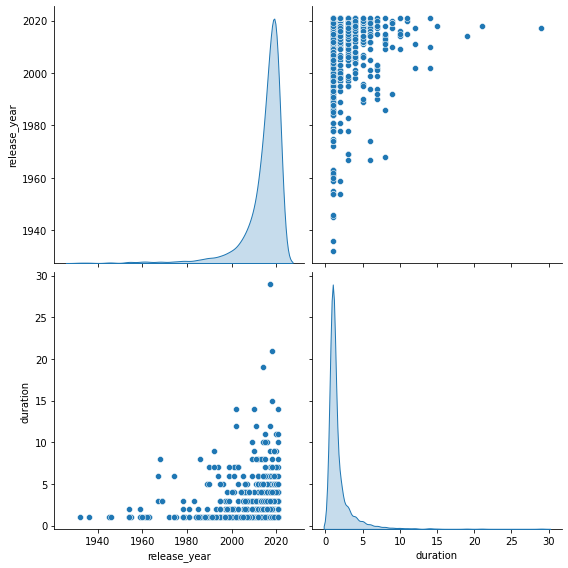

In [20]:
# initial distribution visualizations
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data=df_shows, diag_kind='kde', height=4, aspect=1)

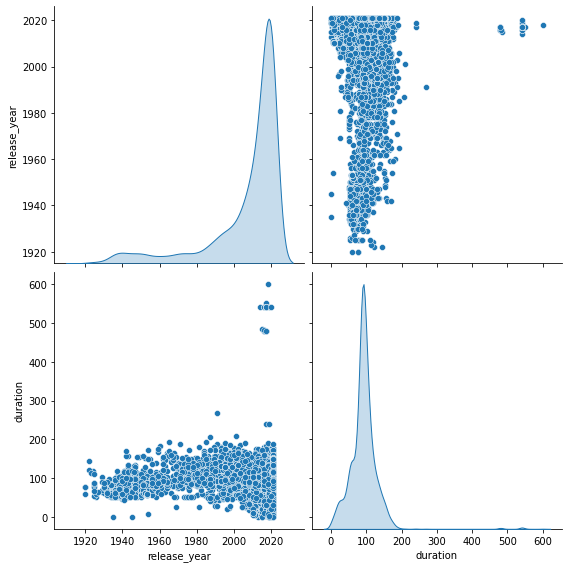

In [21]:
sns.pairplot(data=df_movies, diag_kind='kde', height=4, aspect=1)

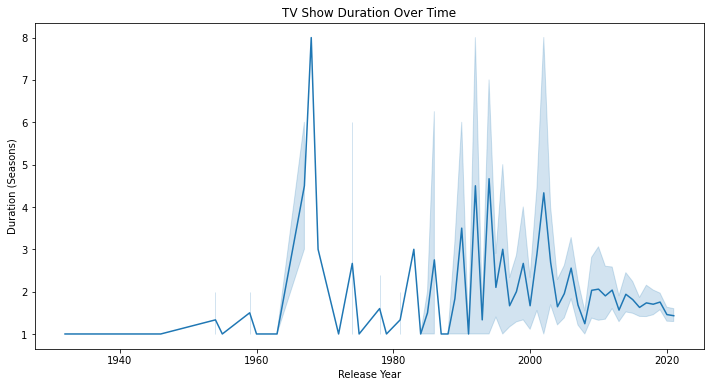

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_shows, x='release_year', y='duration')
plt.title('TV Show Duration Over Time')
plt.xlabel('Release Year')
plt.ylabel('Duration (Seasons)')
plt.show()

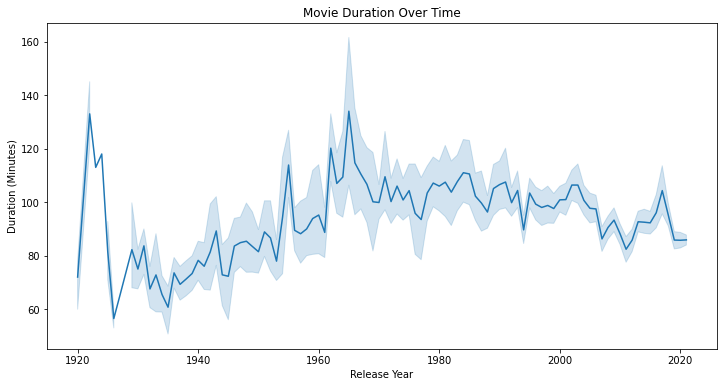

In [23]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_movies, x='release_year', y='duration')
plt.title('Movie Duration Over Time')
plt.xlabel('Release Year')
plt.ylabel('Duration (Minutes)')
plt.show()

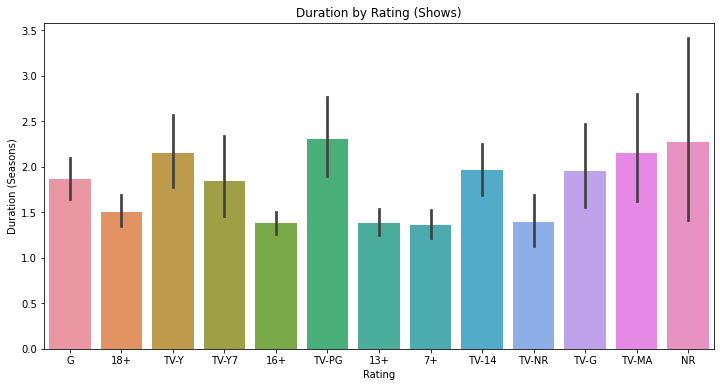

In [24]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_shows, x='rating', y='duration')
plt.title('Duration by Rating (Shows)')
plt.xlabel('Rating')
plt.ylabel('Duration (Seasons)')
plt.show()

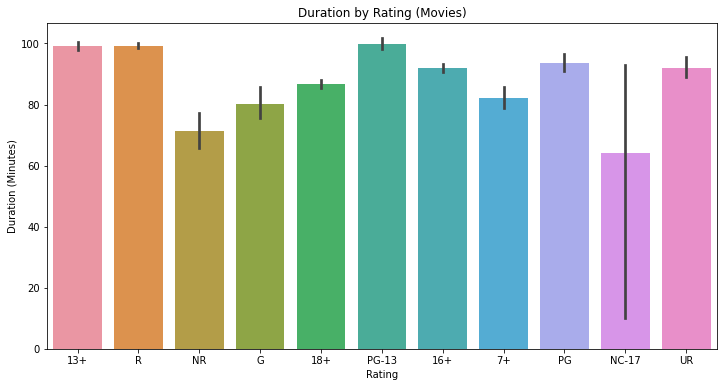

In [25]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_movies, x='rating', y='duration')
plt.title('Duration by Rating (Movies)')
plt.xlabel('Rating')
plt.ylabel('Duration (Minutes)')
plt.show()